# 403 PCA降维和去噪

### MNIST测试

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
import warnings
warnings.filterwarnings('ignore')

mnist = fetch_mldata('MNIST original')

In [2]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']
X_train = np.array(X[:60000], dtype=float)
y_train = np.array(y[:60000], dtype=float)
X_test = np.array(X[60000:], dtype=float)
y_test = np.array(y[60000:], dtype=float)

### 使用kNN
这里没有归一化的过程是因为图像像素在0-255，在一个尺度内，归一化主要用于不同尺度的归一化。

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
%time knn_clf.fit(X_train, y_train)

Wall time: 24.2 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [5]:
%time knn_clf.score(X_test, y_test)

Wall time: 11min 42s


0.9688

### PCA进行降维

In [6]:
from sklearn.decomposition import PCA 

pca = PCA(0.90)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [7]:
X_train_reduction.shape

(60000, 87)

In [8]:
knn_clf = KNeighborsClassifier()
%time knn_clf.fit(X_train_reduction, y_train)

Wall time: 392 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
%time knn_clf.score(X_test_reduction, y_test)

Wall time: 1min 4s


0.9728

降维去除了噪音，有可能准确率更高！

## 使用PCA去噪

### 回忆我们之前的例子
降维的过程可以理解成是去噪。

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
X = np.empty((100, 2))
X[:,0] = np.random.uniform(0., 100., size=100)
X[:,1] = 0.75 * X[:,0] + 3. + np.random.normal(0, 5, size=100)

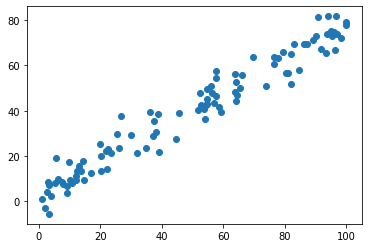

In [12]:
plt.scatter(X[:,0], X[:,1])

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(X)
X_reduction = pca.transform(X)
X_restore = pca.inverse_transform(X_reduction)

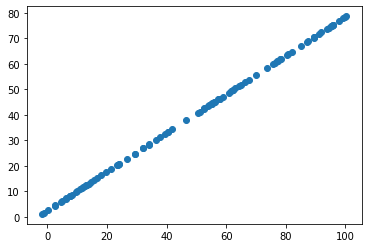

In [14]:
plt.scatter(X_restore[:,0], X_restore[:,1])

### 手写识别的例子

In [15]:
from sklearn import datasets

digits = datasets.load_digits()
X = digits.data
y = digits.target

In [16]:
noisy_digits = X + np.random.normal(0, 4, size=X.shape)

In [17]:
example_digits = noisy_digits[y==0,:][:10]
for num in range(1,10):
    example_digits = np.vstack([example_digits, noisy_digits[y==num,:][:10]])

In [18]:
example_digits.shape

(100, 64)

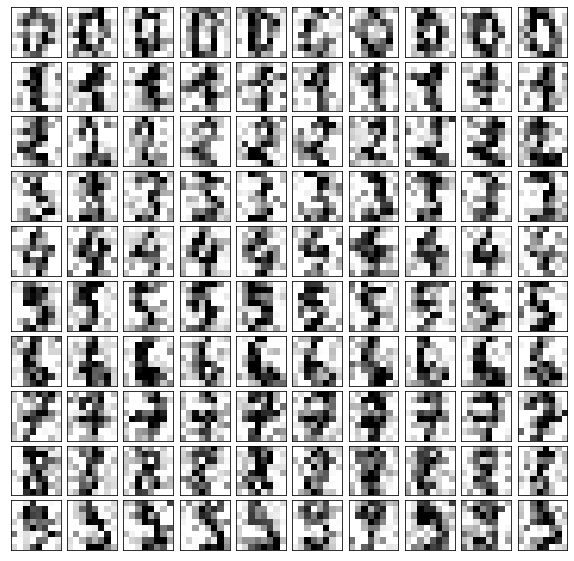

In [19]:
def plot_digits(data):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.1, wspace=0.1)) 
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))

    plt.show()
    
plot_digits(example_digits)

In [20]:
pca = PCA(0.5).fit(noisy_digits)
pca.n_components_

12

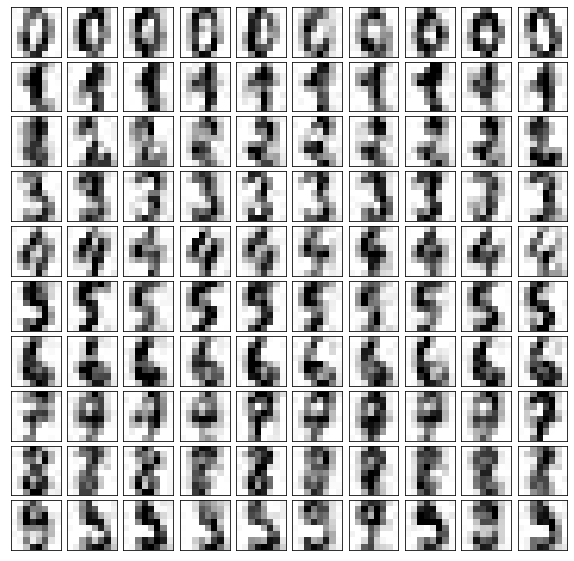

In [21]:
components = pca.transform(example_digits)
filtered_digits = pca.inverse_transform(components)
plot_digits(filtered_digits)